In [ ]:
# Introduction

In [ ]:
## Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'

In [ ]:
# Loading Dataset

In [ ]:
filename = 'Spectroscopy Project/Dataset O.xlsx'
df = pd.read_excel(filename, index_col=0)
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [ ]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

for train_index, test_index in stratified_split.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

print('X_train: {}     Y_train: {} \n X_test: {}     Y_test:{} '.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

X_train: (143, 3406)     Y_train: (143,) 
 X_test: (36, 3406)     Y_test:(36,) 


In [ ]:
def create_model(n_hidden_layers, layer_1_units, layer_2_units, learning_rate):
    model = Sequential()
    model.add(Dense(layer_1_units, input_dim=X.shape[1], activation='relu'))

    # Add hidden layers
    for _ in range(int(n_hidden_layers)-1):
        model.add(Dense(layer_2_units, activation='relu'))

    model.add(Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
def train_model(n_hidden_layers, layer_1_units, layer_2_units, learning_rate):
    mse_list = []
    for train_index, test_index in stratified_split.split(X_train, Y_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model = create_model(n_hidden_layers, layer_1_units, layer_2_units, learning_rate)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_cv_train, y_cv_train, epochs=100, batch_size=32, validation_split=0.2,
                  callbacks=[early_stopping], verbose=0)

        y_pred_test = model.predict(X_cv_test).flatten()
        mse = mean_squared_error(y_cv_test, y_pred_test)
        mse_list.append(mse)

    return -np.mean(mse_list)  # We minimize MSE, so negate it for optimization

In [ ]:
# Define parameter bounds
pbounds = {'n_hidden_layers': (1, 5),
           'layer_1_units': (32, 256),
           'layer_2_units': (32, 256),
           'learning_rate': (0.001, 0.01)}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=train_model, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters
best_params = optimizer.max['params']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

|   iter    |  target   | layer_... | layer_... | learni... | n_hidd... |
-------------------------------------------------------------------------
1/1 [==============================] - 0s 172ms/step
| 1         | -0.01115  | 115.9     | 245.0     | 0.007588  | 3.395     |
1/1 [==============================] - 0s 126ms/step
| 2         | -0.003605 | 66.95     | 66.94     | 0.001523  | 4.465     |
1/1 [==============================] - 0s 141ms/step
| 3         | -0.004306 | 166.6     | 190.6     | 0.001185  | 4.88      |
1/1 [==============================] - 0s 94ms/step
| 4         | -0.004689 | 218.5     | 79.56     | 0.002636  | 1.734     |
1/1 [==============================] - 0s 94ms/step
| 5         | -0.004469 | 100.2     | 149.5     | 0.004888  | 2.165     |
1/1 [==============================] - 0s 125ms/step
| 6         | -0.005411 | 67.78     | 68.75     | 0.003567  | 4.171     |
1/1 [==============================] - 0s 94ms/step
| 7         | -0.01319  | 65.51     | 63

In [ ]:
# Train the model with the best hyperparameters
best_model = create_model(**best_params)
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the training set
y_pred_train = best_model.predict(X_train).flatten()

# Calculate metrics on the training set
mse_train = mean_squared_error(Y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train, y_pred_train)
r2_train = 1 - mse_train / np.var(Y_train)

# Print the results for training set
print('Training Set: ')
print(f'Mean Squared Error: {mse_train}')
print(f'Root Mean Squared Error: {rmse_train}')
print(f'Mean Absolute Error: {mae_train}')
print(f'R-squared: {r2_train}')

5/5 [==============================] - 0s 4ms/step
Training Set: 
Mean Squared Error: 0.0044621966904602964
Root Mean Squared Error: 0.06679967582601204
Mean Absolute Error: 0.05337707069083735
R-squared: 0.9501173054289941


In [ ]:
# Train the model with the best hyperparameters
best_model = create_model(**best_params)
best_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

# Predict on the testing set
y_pred_test = best_model.predict(X_test).flatten()

# Calculate metrics on the testing set
mse_test = mean_squared_error(Y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test, y_pred_test)
r2_test = 1 - mse_test / np.var(Y_test)

# Print the results for testing set
print('\nTesting Set: ')
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'R-squared: {r2_test}')

2/2 [==============================] - 0s 16ms/step

Testing Set: 
Mean Squared Error: 0.005550826658237571
Root Mean Squared Error: 0.07450387008899317
Mean Absolute Error: 0.05250929939250152
R-squared: 0.9423577238419585


In [ ]:
# Predict on the training set
y_pred_train = best_model.predict(X_train).flatten()

# Calculate residuals for training set
residuals_train = Y_train - y_pred_train

# Predict on the testing set
y_pred_test = best_model.predict(X_test).flatten()

# Calculate residuals for testing set
residuals_test = Y_test - y_pred_test

2/2 [==============================] - 0s 0s/step


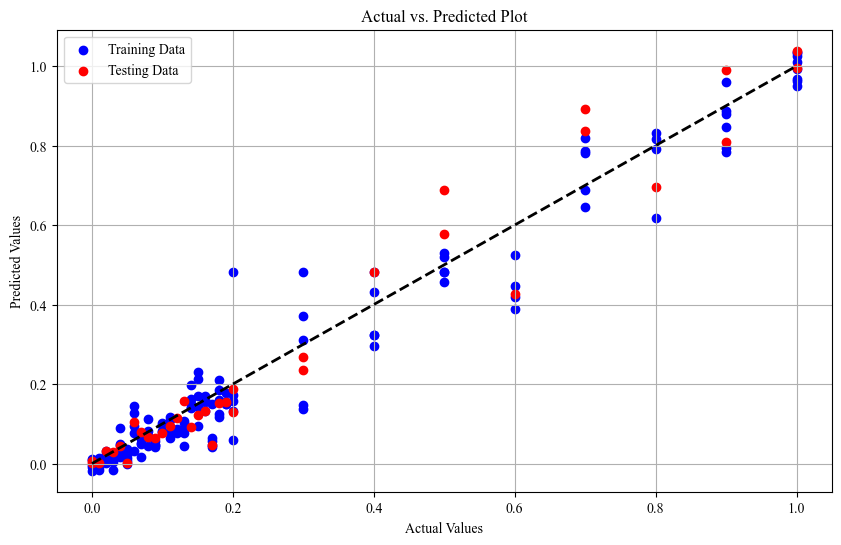

In [ ]:
# Plot actual vs. predicted plot for both training and testing sets
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(Y_train, y_pred_train, color='blue', label='Training Data')

# Plot testing data
plt.scatter(Y_test, y_pred_test, color='red', label='Testing Data')

# Plot diagonal line
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color='black', lw=2, linestyle='--')

plt.title('Actual vs. Predicted Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Save the figure with 600 DPI as a JPEG image
plt.savefig('F17.jpg', dpi=600, format='jpg', bbox_inches='tight')

plt.show()

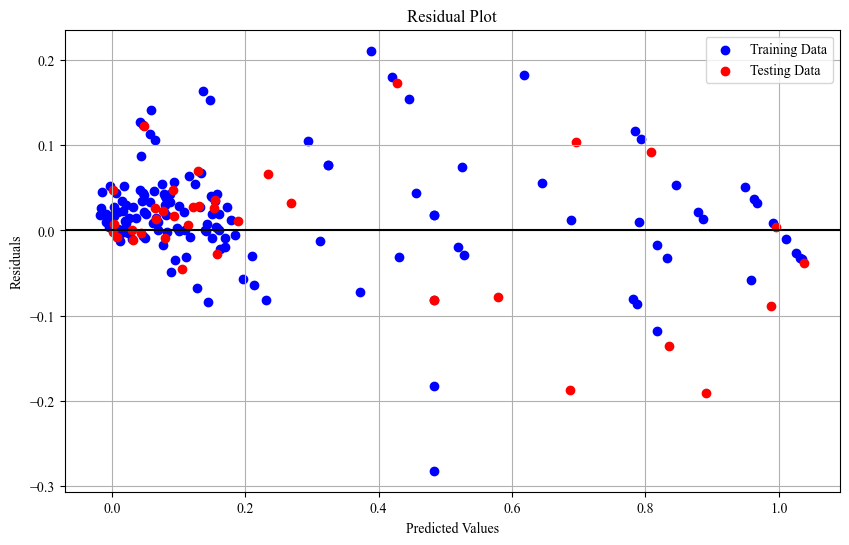

In [ ]:
# Plot residual plot for both training and testing sets
plt.figure(figsize=(10, 6))

# Plot training residuals
plt.scatter(y_pred_train, residuals_train, color='blue', label='Training Data')

# Plot testing residuals
plt.scatter(y_pred_test, residuals_test, color='red', label='Testing Data')

# Plot horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')

plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

# Save the figure with 600 DPI as a JPEG image
plt.savefig('F18.jpg', dpi=600, format='jpg', bbox_inches='tight')

plt.show()